In [6]:
import os
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib
import missingno as msno

import pandas_datareader
import pandas_datareader.data as web
import investpy
import yfinance as yf
import financedatabase as fd

from constants import *
from utils import *
import time
import datetime as dt

import requests
from bs4 import BeautifulSoup as bs
from data_constructor import DataConstructor

pd.set_option('display.width', 250)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)
pd.options.mode.chained_assignment = None

In [ ]:
https://etfdb.com/etf/SPLG/#etf-ticker-profile

In [67]:
url = "https://etfdb.com/etf/SPLG/#etf-ticker-profile"
html = urlopen(url)
bs_obj = BeautifulSoup(html, "html.parser")

In [74]:
# 요청에 성공할 때가 있고 실패할 때가 있음
# 시간간격 + 여러번 시도 기능 만들어야 할 듯 함

import re
from urllib.request import urlopen
from bs4 import BeautifulSoup
symbol = "qqqm".upper()
url = f"https://etfdb.com/etf/{symbol}/#etf-ticker-profile"
html = urlopen(url)
bs_obj = BeautifulSoup(html, "html.parser")
# bs_obj

# find aum
bs_objs = bs_obj.findAll('li')
for i, j in enumerate(bs_objs):
    if ("AUM" in str(j)) and ("pull-right" in str(j)):
        print(i)
        print(j)
        print(j.find_all('span')[1].get_text().replace("[ ,]",""))
        break

# find shares outstanding

105
<li>
<span>AUM</span>
<span class="pull-right">$5,818.3 M</span>
</li>
$5,818.3 M


In [46]:
re.sub("[ ,$]", "", j.find_all('span')[1].get_text())

'272816.0M'

In [10]:
bs_obj.findAll('div')[0]

<div class="header-area">
<div class="container" data-dfp-unit="prepend_body"></div>
<div data-ad-slot-defer="" data-dfp-unit="append_header" data-dfp-unit-remove-iframe="true" data-dfp-unit-served='{ "append": "&lt;script&gt;window.preventFixHeaderArea = true;&lt;/script&gt;" }' id="append_header"></div> <script> googletag.cmd.push(function() {
      googletag.defineOutOfPageSlot('/21804333245/mitre_webpage', 'append_header').setTargeting('uri', ["/etf/VOO"]).setTargeting('tags', ["etf", "VOO", "vanguard", "sp-500-index", "large-cap-growth-equities", "root", "asset-class", "equity", "size", "large-cap", "style", "blend", "region", "structure", "north-america", "us", "investment-style", "consistent-growth", "socially-responsible", "dividend-frequency", "quarterly", "Currency Hedged", "Equity", "Ireland Exposure", "Passive", "Rising Interest Rates", "United States", "Blend Equity", "Blend", "Equity Asset Class", "North America", "Equity ETFs", "Consistent Growth", "Large Cap Equity", "E

In [11]:
bs_obj.findAll("", {"class":"pull-right"})

[]

In [12]:
bs_obj.get_text().replace("\n","")

'Vanguard S&P 500 ETF   ETF DatabaseChannelsActive ETFAlternativesBeyond Basic BetaChina InsightsClimate InsightsCommoditiesCore StrategiesCryptoDisruptive TechnologyDividendDual ImpactEmerging MarketsEnergy InfrastructureESGETF Building BlocksETF Education ETF StrategistFixed IncomeFree Cash FlowFuture ETFsGlobal DiversificationGold & Silver Investing Innovative ETFsInstitutional Income StrategiesLeveraged & InverseManaged FuturesMegatrendsModern AlphaMulti-AssetPortfolio StrategiesRetirement IncomeThematic InvestingVolatility ResourceToolsETF ScreenerETF Country Exposure ToolETF Sector Tracker Tool ETF Database CategoriesHead-To-Head ETF Comparison ToolETF Stock Exposure ToolETF Issuer Fund FlowsIndexesMutual Fund To ETF ConverterETF Data for JournalistsETF NerdsResearchFirst Bitcoin ETFETF EducationEquity InvestingDividend ETFsLeveraged ETFsInverse ETFsTop ETF SectorsTop ETF IssuersTop ETF IndustriesWebcastsThemesAI ETFsBlockchain ETFsSee all Thematic Investing ETF themesESG Investi

In [13]:
import investiny

In [14]:
investiny.search_assets(query="QQQ")

ConnectionError: Request to Investing.com API failed with error code: 403.

In [ ]:
investiny.info('qqq')

ConnectionError: Request to Investing.com API failed with error code: 403.

In [ ]:
investpy.get_etf_recent_data('qqq', country='united states')

RuntimeError: ERR#0019: etf qqq not found, check if it is correct.

In [ ]:
from yahoofinancials import YahooFinancials
qqq = YahooFinancials("tip")
print(qqq.get_market_cap())
print(qqq.get_num_shares_outstanding())

19097419776
None


# Get ETF History
- 모듈별 특징
    - investpy
        - 응답시간으로 유추해보면 일자에 일일이 요청을 날려 데이터를 받아오는 듯 함
        - 1700년쯤으로 설정하면 너무 많이 시도해서 막힘
        - 적당히 1970-1990년 정도로 하기
    - pandas datareader - yahoo finance
        - 단순 입력으로 얻을 수 있는 가장 과거날짜: https://github.com/ranaroussi/yfinance/issues/25
        - 유닉스타임으로 날짜 바꾸기: https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=tamiel&logNo=221872429636 -> 잘안됨
    - yfinance
        - price, divdidend, split의 history를 한방에 획득 가능!!
        - `period="max"`와 같이 쉽게 히스토리 데이터 획득 가능
        - `pip install yfinance`로 설치 시 S&P500 1950년부터 획득 가능
        - `pip install yfinance==0.1.63`으로 설치 시 S&P500 1927년부터 획득 가능: https://github.com/ranaroussi/yfinance/issues/980
- 저장 방식(2안으로 결정)
    - 1안: 통째로 저장 -> 통째로 로드 -> 통째로 전처리
    - 2안: 종목별 저장 -> 종목별 로드 -> 종목별 전처리 -> 하나로 합치기
    - 3안: 종목별 전처리 후 저장 -> 하나로 합치기





<AxesSubplot:xlabel='Date'>

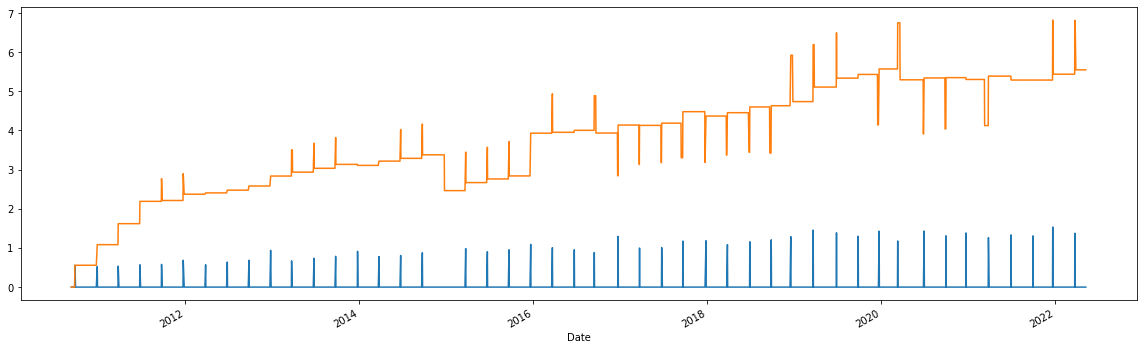

In [ ]:
df.set_index('Date')['Dividends'].plot(figsize=(20,6))
df.set_index('Date')['Dividends'].rolling(window='365d').sum().plot()

### Fred: 기준금리, 소비자물가, 인플레이션 등등
- https://ecodemy.cafe24.com/fedrfund.html
- https://seek-and-eat.tistory.com/88

### 경제 위기
- https://en.wikipedia.org/wiki/List_of_recessions_in_the_United_States
- search the word 'recession': https://www.stlouisfed.org/education/-/media/project/frbstl/stlouisfed/education/lessons/pdf/fred-gdp-stacking.pdf
- https://fredhelp.stlouisfed.org/fred/data/understanding-the-data/recession-bars/
- https://blog.stata.com/2020/02/13/adding-recession-shading-to-time-series-graphs/
- https://fredhelp.stlouisfed.org/fred/data/understanding-the-data/recession-bars/
- https://seek-and-eat.tistory.com/88

In [ ]:
start, end = (dt.datetime(1800, 1, 1), dt.datetime.today())
recession = web.DataReader('USREC', 'fred', start, end)
recession = recession.reset_index(drop=False)
recession['yyyy-mm'] = recession['DATE'].dt.to_period('M').astype('str')
recession

,DATE,USREC,yyyy-mm
0,1854-12-01,1,1854-12
1,1855-01-01,0,1855-01
2,1855-02-01,0,1855-02
3,1855-03-01,0,1855-03
4,1855-04-01,0,1855-04
...,...,...,...
2004,2021-12-01,0,2021-12
2005,2022-01-01,0,2022-01
2006,2022-02-01,0,2022-02
2007,2022-03-01,0,2022-03


- master
- hisotry
- summary
    - 끌어올 수 있는 거
    - 직접 구해야 하는거
        - 배당률 -> T12M, T6M
        - 최근 1년 배당 횟수 -> 반기, 분기, 연

- market cap
    - 시총
- shares outstanding(https://www.mk.co.kr/dic/m/view.php?idx=6091)
    - 발행주식수
    - 기업이 발행하여 일반 투자자가 소유하고 있는 주식수
- AUM(assets under management) = Net Assets = Market Cap
    - The AUM of an ETF is calculated by multiplying shares outstanding by the market price per share
    - shares outstanding * 주당 가격
- total asset(https://m.blog.naver.com/kyangsy0322/222243563773):
    - 순자산 + 부채를 의미하는 듯